In [1]:
import sys
sys.path.append('..')

In [2]:
import models
device = "mps"
#runtime: 1m 13s on Macbook M2 Chip
mt = models.load_model("gptj", device=device, fp16=True)

tokenizer_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

For convenience, here's a little API for getting GPT-J completions.

In [3]:
import torch

#runtime: 55sec
@torch.inference_mode()
def complete(prompt, max_new_tokens=1):
    inputs = mt.tokenizer(prompt, return_tensors="pt").to(device)
    outputs = mt.model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=mt.tokenizer.pad_token_id,
    )
    return mt.tokenizer.batch_decode(outputs)[0]

complete("The Eiffel Tower is located in the city of")

'The Eiffel Tower is located in the city of Paris'

Which attention heads, at layers after the ROME-optimal layer, look at the last subject token?

In [18]:
from collections import defaultdict
import tokenizer_utils
import baukit

from tqdm.auto import tqdm

# (further reduces memory usage and computational overhead)
@torch.inference_mode()
def compute_attns_and_words(prompt_template, subject, layers, ablates=None, subject_token_offset=-1):
    prompt = prompt_template.format(subject)
    si, sj = tokenizer_utils.find_token_range(prompt, subject, tokenizer=mt.tokenizer)
    print(f'si,sj is ({si},{sj})')

    #subject_token_offset is the offset within the subject-range
    #defaults to last token in subject-range.
    if subject_token_offset < 0:
        ti = sj + subject_token_offset
    else:
        ti = si + subject_token_offset

    z_layernames = [f"transformer.h.{layer}" for layer in layers]
    attn_layernames = [f"transformer.h.{layer}.attn.attn_dropout" for layer in layers]
    
    edit_output = None
    # if ablates is not None:
    #     ablate_heads_by_layer = defaultdict(list)
    #     for (layer, head) in ablates:
    #         ablate_layername = f"transformer.h.{layer}.attn.attn_dropout"
    #         ablate_heads_by_layer[ablate_layername].append(head)

    #     def edit_output(x, layer):
    #         if layer not in ablate_heads_by_layer:
    #             return x
    #         for head in ablate_heads_by_layer[layer]:
    #             x[:, head, -1, ti] = 0
    #         return x

    with baukit.TraceDict(mt.model, (*z_layernames, *attn_layernames), edit_output=edit_output) as ret:
        complete(prompt)

    attns = []
    words = []
    #goes through z/attn layers and appends last-token attention and probs
    for z_layername, attn_layername in tqdm(tuple(zip(z_layernames, attn_layernames))):
        attn = ret[attn_layername].output[0, :, -1, ti]
        attns.append(attn)

        z = ret[z_layername].output[0][:, -1]
        logits = mt.lm_head(z)
        token_id = logits.argmax(dim=-1).item()
        token_prob = torch.softmax(logits.float(), dim=-1).max()
        word = mt.tokenizer.decode(token_id)
        word = word.strip()
        words.append(f"{word} ({token_prob:.2f})")
    return attns, words

si,sj is (0,4)


  0%|          | 0/27 [00:00<?, ?it/s]

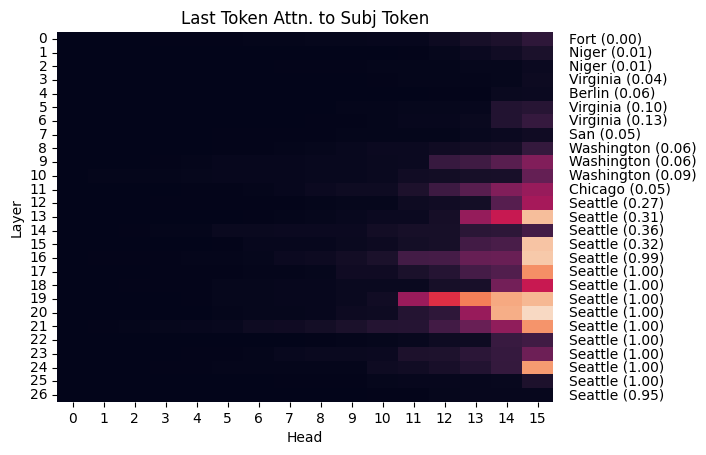

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

#average inference time: 40 seconds
#"Looks only at the 'Needle' part"?
subject = "The Space Needle"
prompt_template = "{} is located in the city of"
layers = range(27)
attns, words = compute_attns_and_words(prompt_template,subject,layers,None,subject_token_offset=-1)

#sort (head, attn) list by attention paid.
heads_ordered_list = [sorted(enumerate(attn.tolist()), key=lambda kv: kv[-1]) for attn in attns]
heads_ordered = [[x[0] for x in heads] for heads in heads_ordered_list]
attns_ordered = [[x[1] for x in heads] for heads in heads_ordered_list]

sns.heatmap(
    torch.tensor(attns_ordered).numpy(),
    yticklabels=layers,
    cbar=False,
    vmin=0,
    vmax=1,
    # Uncomment this to see the ID.
#     annot=heads_ordered
)

plt.title("Last Token Attn. to Subj Token")
plt.ylabel("Layer")
plt.xlabel("Head")

# plt.yaxis.tick_left()
for i, word in enumerate(words):
    plt.text(attns[0].shape[0] + 0.5, i + 0.5, word, va='center')